# 🛩️ Aircraft Engine RUL Prediction - ML/DL Models

## Remaining Useful Life Prediction using Machine Learning & Deep Learning

This notebook builds and compares multiple approaches for predicting Remaining Useful Life (RUL) of aircraft turbofan engines using the NASA C-MAPSS dataset.

### Models Implemented:
1. **Random Forest Regressor** - Baseline ML model
2. **Gradient Boosting (XGBoost)** - Advanced ensemble method
3. **LSTM Neural Network** - Deep learning for sequence modeling
4. **1D CNN** - Convolutional approach for time series

### Evaluation Metric:
The PHM scoring function penalizes late predictions more heavily than early ones:
$$s = \sum_{i=1}^{n} \begin{cases} e^{-d/a_1} - 1 & \text{if } d < 0 \text{ (early)} \\ e^{d/a_2} - 1 & \text{if } d \geq 0 \text{ (late)} \end{cases}$$
where $d = \hat{RUL} - RUL_{true}$, $a_1 = 13$, $a_2 = 10$


## 1. Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Deep Learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (Dense, LSTM, Dropout, Conv1D, MaxPooling1D, 
                                          Flatten, BatchNormalization, Input, Bidirectional)
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
    print(f"✅ TensorFlow version: {tf.__version__}")
except ImportError:
    print("⚠️ TensorFlow not installed. Run: pip install tensorflow")
    TENSORFLOW_AVAILABLE = False

warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

COLORS = {
    'primary': '#1E3A5F',
    'secondary': '#3D7EAA',
    'accent': '#F39C12',
    'success': '#27AE60',
    'danger': '#E74C3C',
    'warning': '#F1C40F'
}

print("✅ Libraries loaded successfully!")


⚠️ TensorFlow not installed. Run: pip install tensorflow
✅ Libraries loaded successfully!


## 2. Load and Prepare Data


In [3]:
# Data path
DATA_PATH = Path(r"C:\Users\Prshant Verma\Documents\Projects\DataSets\aircraft-engine-failure-data")

# Column definitions
index_columns = ['unit_number', 'time_cycles']
operational_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']

sensor_columns = [
    'T2', 'T24', 'T30', 'T48', 'T50', 'P2', 'P15', 'P30',
    'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB',
    'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

column_names = index_columns + operational_settings + sensor_columns

# Sensors to drop (low variance based on EDA)
drop_sensors = ['T2', 'P2', 'P15', 'Nf_dmd', 'PCNfR_dmd', 'farB']

# Maximum RUL cap (piecewise linear degradation assumption)
RUL_CAP = 125


In [23]:
def load_dataset(dataset_id='FD001'):
    """Load train, test, and RUL data for a given dataset."""
    
    train_df = pd.read_csv(
        DATA_PATH / f'train_{dataset_id}.txt',
        sep='\\s+', header=None, names=column_names
    )
    
    test_df = pd.read_csv(
        DATA_PATH / f'test_{dataset_id}.txt',
        sep='\\s+', header=None, names=column_names
    )
    
    rul_df = pd.read_csv(
        DATA_PATH / f'RUL_{dataset_id}.txt',
        sep='\\s+', header=None, names=['RUL']
    )
    
    return train_df, test_df, rul_df


def compute_rul(df, rul_cap=RUL_CAP):
    """Compute RUL for training data with optional capping."""
    max_cycles = df.groupby('unit_number')['time_cycles'].max()
    
    df = df.copy()
    df['RUL'] = df.apply(
        lambda row: max_cycles[row['unit_number']] - row['time_cycles'], 
        axis=1
    )
    
    # Cap RUL (piecewise linear assumption)
    if rul_cap:
        df['RUL'] = df['RUL'].clip(upper=rul_cap)
    
    return df


def add_features(df, w):
    """Add rolling statistics and derived features."""
    df = df.copy()
    
    # Useful sensors (excluding low variance)
    useful_sensors = [s for s in sensor_columns if s not in drop_sensors]
    
    # Rolling statistics per engine
    for sensor in useful_sensors:
        # Rolling mean (window = 5 cycles)
        df[f'{sensor}_roll_mean_{w}'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean()
        )
        
        # Rolling std (window = 5 cycles)
        df[f'{sensor}_roll_std_{w}'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=w, min_periods=1).std()
        )
    
    # Fill NaN from rolling operations
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df


# Load FD001 dataset
train_df, test_df, rul_df = load_dataset('FD001')

# Compute RUL for training data
train_df = compute_rul(train_df)

# Add engineered features
train_df = add_features(train_df, w=5)

test_df = add_features(test_df, w=5)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Number of features: {len([c for c in train_df.columns if c not in index_columns + ['RUL']])}")


Training data shape: (20631, 57)
Test data shape: (13096, 56)
Number of features: 54


In [24]:
train_df

,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T48,T50,...,NRc_roll_mean_5,NRc_roll_std_5,BPR_roll_mean_5,BPR_roll_std_5,htBleed_roll_mean_5,htBleed_roll_std_5,W31_roll_mean_5,W31_roll_std_5,W32_roll_mean_5,W32_roll_std_5
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.620000,5.041671,8.419500,0.008697,392.000000,0.000000,39.060000,0.042426,23.419000,0.003253
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8135.055000,5.041671,8.425650,0.008697,392.000000,0.000000,39.030000,0.042426,23.421300,0.003253
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8134.446667,3.717450,8.423033,0.007640,391.333333,1.154701,39.003333,0.055076,23.395600,0.044573
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8134.292500,3.050906,8.409325,0.028117,391.500000,1.000000,38.972500,0.076322,23.390175,0.037977
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8134.194000,2.651326,8.413340,0.025953,391.800000,1.095445,38.958000,0.073621,23.393020,0.033498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8141.130000,2.446753,8.520120,0.027684,395.800000,1.643168,38.408000,0.163003,23.079640,0.086540
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8139.738000,2.750731,8.525060,0.022507,395.400000,1.516575,38.356000,0.142583,23.096120,0.093479
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8139.544000,2.578358,8.529500,0.028242,395.600000,1.816590,38.350000,0.137113,23.078180,0.116735
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.468000,2.579316,8.532980,0.028081,395.800000,1.643168,38.332000,0.138094,23.064500,0.112731


## 3. Feature Preparation


In [25]:
# Define feature columns (exclude index and target)
feature_columns = [c for c in train_df.columns if c not in index_columns + ['RUL']]

# Remove low variance sensors from features
feature_columns = [c for c in feature_columns if not any(s in c for s in drop_sensors)]

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns[:10]}...")  # Show first 10


Number of features: 45
Features: ['op_setting_1', 'op_setting_2', 'op_setting_3', 'T30', 'T48', 'T50', 'P30', 'Nf', 'Nc', 'Ps30']...


In [26]:
# Prepare training data for ML models
X_train_full = train_df[feature_columns].values
y_train_full = train_df['RUL'].values

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Training set: (16504, 45)
Validation set: (4127, 45)


In [27]:
# Prepare test data
# For test set, we use the LAST observation of each engine
test_last = test_df.groupby('unit_number').last().reset_index()

X_test = test_last[feature_columns].values
X_test_scaled = scaler.transform(X_test)
y_test = rul_df['RUL'].values

print(f"Test set: {X_test_scaled.shape}")
print(f"True RUL values: {len(y_test)}")


Test set: (100, 45)
True RUL values: 100


## 4. Evaluation Metrics


In [29]:
def phm_score(y_true, y_pred, a1=13, a2=10):
    """
    PHM Challenge scoring function.
    Penalizes late predictions more heavily than early predictions.
    
    Args:
        y_true: True RUL values
        y_pred: Predicted RUL values
        a1: Parameter for early predictions (default: 13)
        a2: Parameter for late predictions (default: 10)
    
    Returns:
        Total PHM score (lower is better)
    """
    d = y_pred - y_true  # Estimated - True
    
    scores = np.where(
        d < 0,
        np.exp(-d / a1) - 1,  # Early prediction
        np.exp(d / a2) - 1    # Late prediction
    )
    
    return np.sum(scores)


def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive model evaluation."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    score = phm_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} Performance")
    print(f"{'='*50}")
    print(f"  RMSE:      {rmse:.2f} cycles")
    print(f"  MAE:       {mae:.2f} cycles")
    print(f"  R² Score:  {r2:.4f}")
    print(f"  PHM Score: {score:.2f} (lower is better)")
    
    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2, 'phm_score': score}


def plot_predictions(y_true, y_pred, model_name="Model"):
    """Plot predicted vs actual RUL."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.6, c=COLORS['primary'], s=50)
    axes[0].plot([0, max(y_true)], [0, max(y_true)], 'r--', linewidth=2, label='Perfect prediction')
    axes[0].set_xlabel('True RUL (cycles)', fontsize=12)
    axes[0].set_ylabel('Predicted RUL (cycles)', fontsize=12)
    axes[0].set_title(f'{model_name}: Predicted vs True RUL', fontsize=14, fontweight='bold')
    axes[0].legend()
    
    # Error distribution
    errors = y_pred - y_true
    axes[1].hist(errors, bins=30, color=COLORS['secondary'], edgecolor='white', alpha=0.8)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    axes[1].axvline(errors.mean(), color='green', linestyle='-', linewidth=2, 
                    label=f'Mean error: {errors.mean():.1f}')
    axes[1].set_xlabel('Prediction Error (cycles)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title(f'{model_name}: Error Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Store results for comparison
results = []


## 5. Model 1: Random Forest Regressor


🌲 Training Random Forest Regressor...

--- Validation Set ---

📊 Random Forest (Val) Performance
  RMSE:      15.96 cycles
  MAE:       11.11 cycles
  R² Score:  0.8499
  PHM Score: 40999.65 (lower is better)

--- Test Set ---

📊 Random Forest (Test) Performance
  RMSE:      18.99 cycles
  MAE:       14.10 cycles
  R² Score:  0.7912
  PHM Score: 944.79 (lower is better)


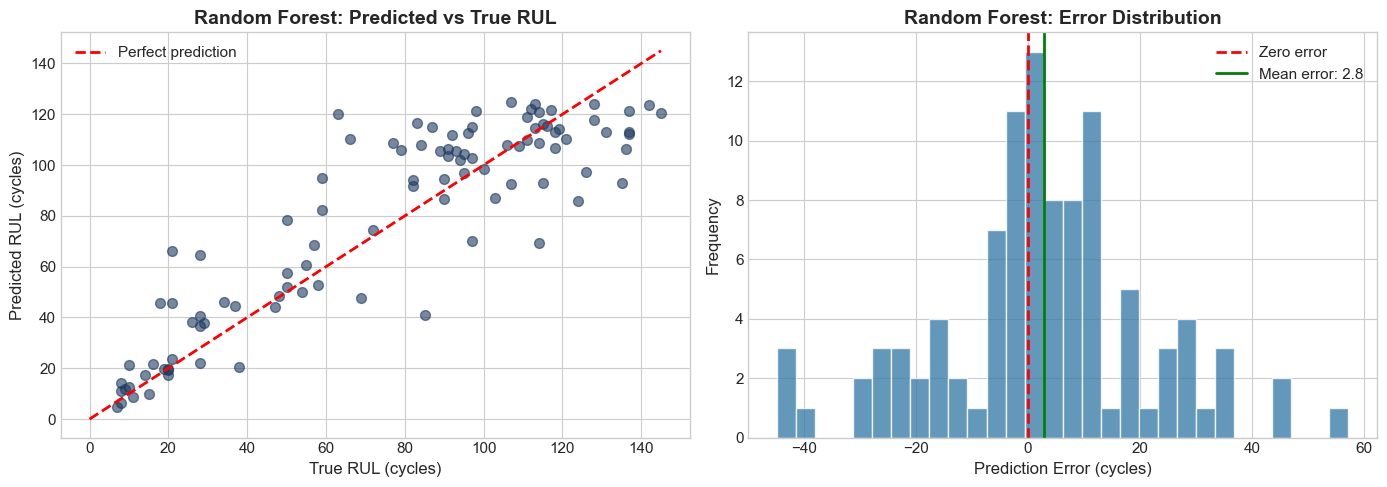

In [30]:
print("🌲 Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test_scaled)

# Evaluate on validation set
print("\n--- Validation Set ---")
rf_val_result = evaluate_model(y_val, rf_val_pred, "Random Forest (Val)")

# Evaluate on test set
print("\n--- Test Set ---")
rf_test_result = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")
results.append(rf_test_result)

# Plot predictions
plot_predictions(y_test, rf_test_pred, "Random Forest")


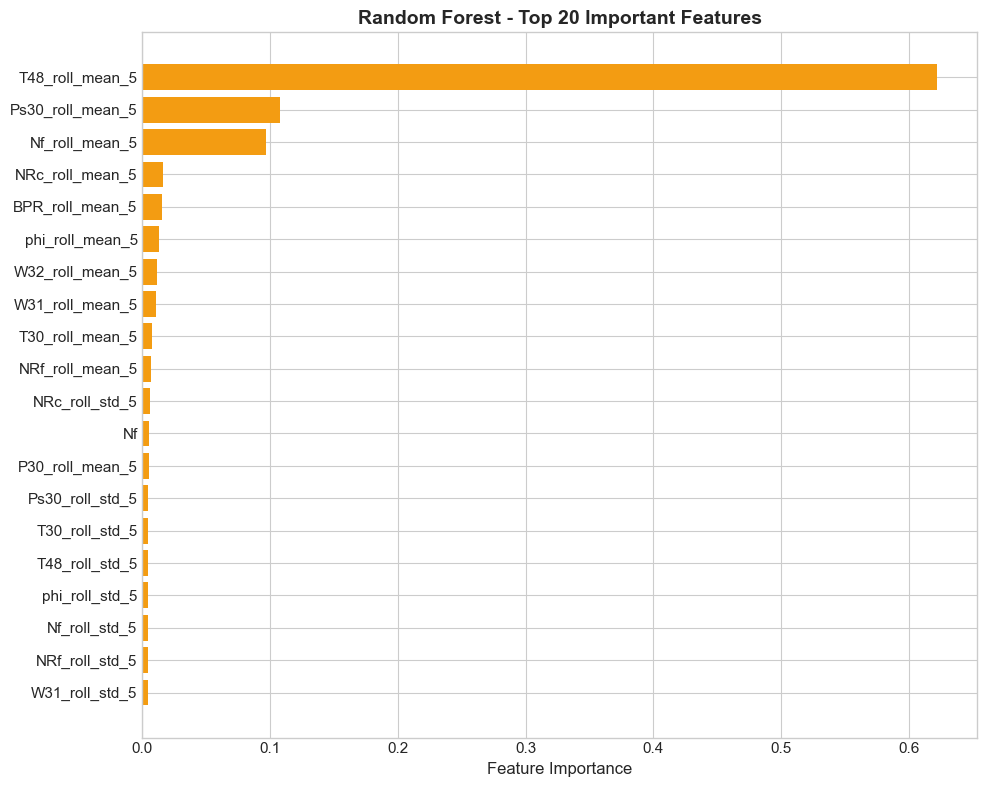

In [31]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(top_features['feature'], top_features['importance'], color=COLORS['accent'])
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest - Top 20 Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## 6. Model 2: XGBoost Regressor


🚀 Training XGBoost Regressor...



--- Validation Set ---

📊 XGBoost (Val) Performance
  RMSE:      15.78 cycles
  MAE:       11.00 cycles
  R² Score:  0.8532
  PHM Score: 38756.70 (lower is better)

--- Test Set ---

📊 XGBoost (Test) Performance
  RMSE:      18.35 cycles
  MAE:       13.68 cycles
  R² Score:  0.8051
  PHM Score: 922.84 (lower is better)


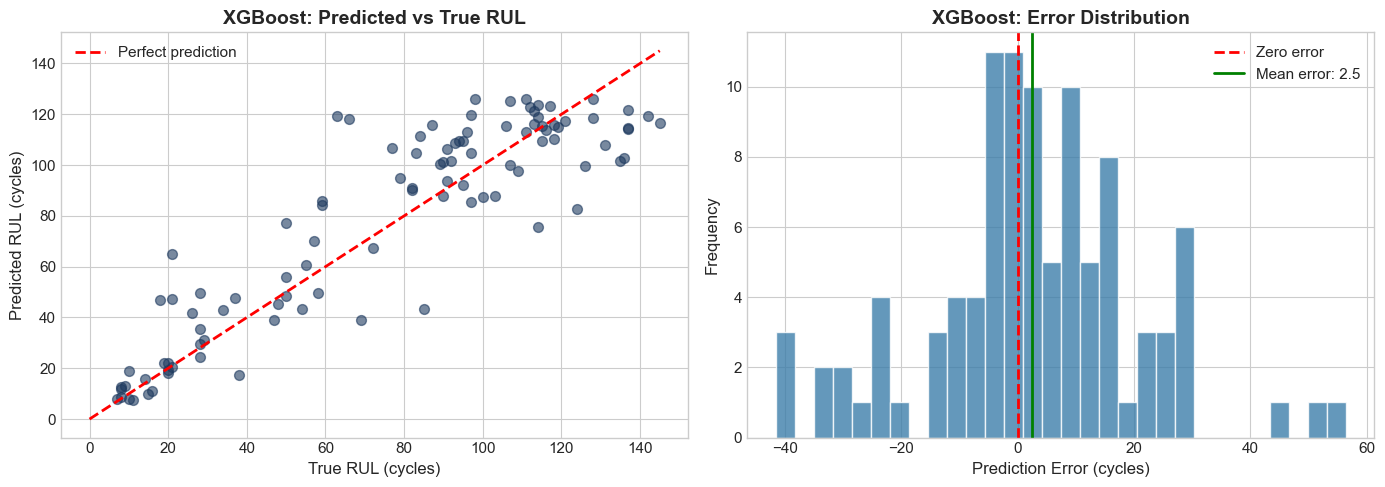

In [32]:
if XGBOOST_AVAILABLE:
    print("🚀 Training XGBoost Regressor...")
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predictions
    xgb_val_pred = xgb_model.predict(X_val)
    xgb_test_pred = xgb_model.predict(X_test_scaled)
    
    # Evaluate
    print("\n--- Validation Set ---")
    xgb_val_result = evaluate_model(y_val, xgb_val_pred, "XGBoost (Val)")
    
    print("\n--- Test Set ---")
    xgb_test_result = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")
    results.append(xgb_test_result)
    
    # Plot predictions
    plot_predictions(y_test, xgb_test_pred, "XGBoost")
else:
    print("⚠️ XGBoost not available. Skipping...")


## 10. Model Comparison


In [33]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("📊 MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80)
results_df



📊 MODEL COMPARISON - TEST SET PERFORMANCE


,model,rmse,mae,r2,phm_score
0,Random Forest (Test),18.989721,14.098346,0.791177,944.786941
1,XGBoost (Test),18.347692,13.676553,0.805059,922.843065


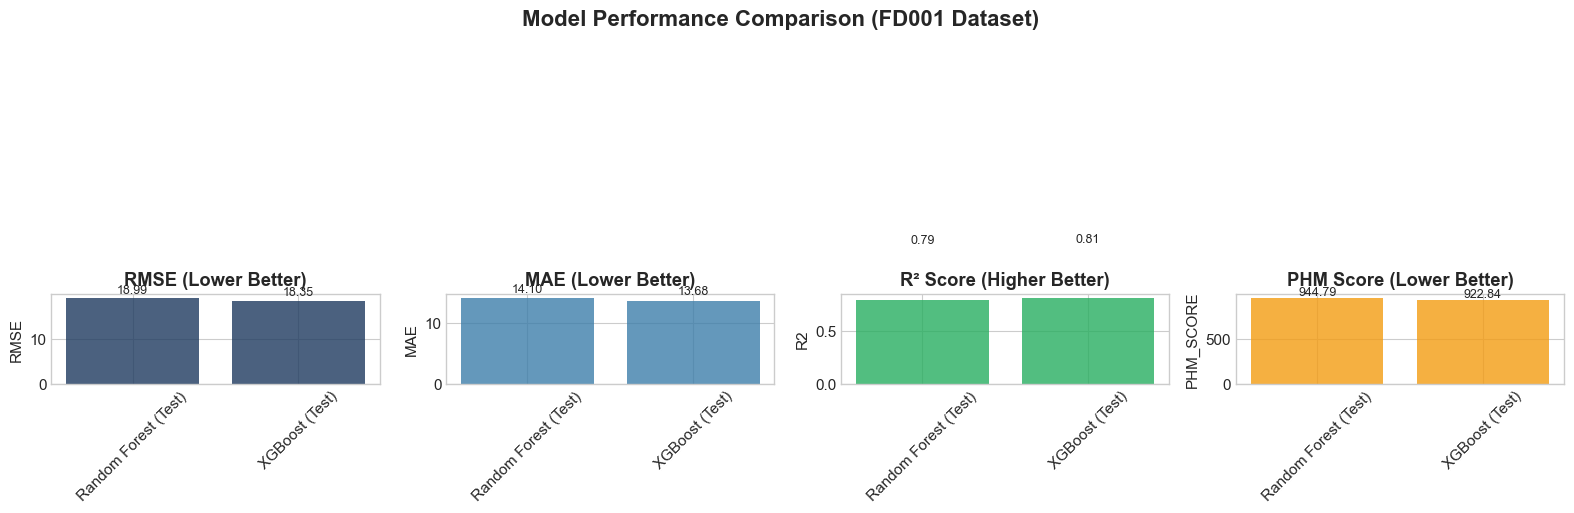

In [34]:
# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

metrics = ['rmse', 'mae', 'r2', 'phm_score']
titles = ['RMSE (Lower Better)', 'MAE (Lower Better)', 'R² Score (Higher Better)', 'PHM Score (Lower Better)']
colors_list = [COLORS['primary'], COLORS['secondary'], COLORS['success'], COLORS['accent']]

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    bars = ax.bar(results_df['model'], results_df[metric], color=colors_list[i], alpha=0.8)
    ax.set_ylabel(metric.upper())
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison (FD001 Dataset)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [35]:
# Best model identification
best_rmse = results_df.loc[results_df['rmse'].idxmin()]
best_phm = results_df.loc[results_df['phm_score'].idxmin()]

print("\n" + "="*80)
print("🏆 BEST MODELS")
print("="*80)
print(f"\n📌 Best by RMSE: {best_rmse['model']}")
print(f"   RMSE = {best_rmse['rmse']:.2f}, PHM Score = {best_rmse['phm_score']:.2f}")

print(f"\n📌 Best by PHM Score: {best_phm['model']}")
print(f"   PHM Score = {best_phm['phm_score']:.2f}, RMSE = {best_phm['rmse']:.2f}")



🏆 BEST MODELS

📌 Best by RMSE: XGBoost (Test)
   RMSE = 18.35, PHM Score = 922.84

📌 Best by PHM Score: XGBoost (Test)
   PHM Score = 922.84, RMSE = 18.35


## 11. Visualize All Predictions


## 12. Summary and Conclusions


In [37]:
print("="*80)
print("📋 SUMMARY: REMAINING USEFUL LIFE PREDICTION")
print("="*80)

print("\n🎯 PROBLEM")
print("   Predict the number of operational cycles remaining before")
print("   aircraft turbofan engine failure using sensor data.")

print("\n📊 DATASET: NASA C-MAPSS FD001")
print("   • 100 training engines (run to failure)")
print("   • 100 test engines")
print("   • 21 sensor measurements + 3 operational settings")
print("   • Single operating condition, single fault mode (HPC degradation)")

print("\n🔧 APPROACH")
print("   1. Feature Engineering:")
print("      - Rolling statistics (mean, std)")
print("      - Dropped low-variance sensors")
print("      - RUL capping at 125 cycles (piecewise linear)")
print("   ")
print("   2. Models Implemented:")
print("      - Random Forest Regressor")
print("      - XGBoost Regressor") 


print("\n📈 KEY INSIGHTS")
print("   • Ensemble methods work well without sequence modeling")
print("   • PHM scoring penalizes late predictions more heavily")
print("   • Feature engineering significantly improves performance")

print("\n🚀 POTENTIAL IMPROVEMENTS")
print("   • Bidirectional LSTM / Attention mechanisms")
print("   • Ensemble of multiple models")
print("   • Hyperparameter tuning with cross-validation")
print("   • Physics-informed neural networks")
print("   • Test on more complex datasets (FD002, FD003, FD004)")

print("\n" + "="*80)


📋 SUMMARY: REMAINING USEFUL LIFE PREDICTION

🎯 PROBLEM
   Predict the number of operational cycles remaining before
   aircraft turbofan engine failure using sensor data.

📊 DATASET: NASA C-MAPSS FD001
   • 100 training engines (run to failure)
   • 100 test engines
   • 21 sensor measurements + 3 operational settings
   • Single operating condition, single fault mode (HPC degradation)

🔧 APPROACH
   1. Feature Engineering:
      - Rolling statistics (mean, std)
      - Dropped low-variance sensors
      - RUL capping at 125 cycles (piecewise linear)
   
   2. Models Implemented:
      - Random Forest Regressor
      - XGBoost Regressor

📈 KEY INSIGHTS
   • Ensemble methods work well without sequence modeling
   • PHM scoring penalizes late predictions more heavily
   • Feature engineering significantly improves performance

🚀 POTENTIAL IMPROVEMENTS
   • Bidirectional LSTM / Attention mechanisms
   • Ensemble of multiple models
   • Hyperparameter tuning with cross-validation
   • Phys

---

## 📚 References

1. Saxena, A., Goebel, K., Simon, D., & Eklund, N. (2008). **Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation**. International Conference on Prognostics and Health Management (PHM08).

2. NASA Prognostics Center of Excellence Data Repository: [https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

---

**End of Notebook**
